In [11]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,roc_auc_score,roc_curve,auc,confusion_matrix,make_scorer
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# Uçuş Rötarları ve İptallerinin Analizi
---

### Proje Detayları
- Time Series Analysis and Forecasting için tarih-saat oluşturulmalıdır, böylece çizim ve zaman serisi analizi daha etkili bir şekilde gerçekleştirilebilir.
- Kalkış ve varış saatleri düzeltilmelidir, bu sayede verilerin doğruluğu sağlanabilir.
- Kopyalar kontrol edilmelidir, böylece veri setinde tutarsızlıklar ve tekrarlanan bilgiler tespit edilebilir.
- HAVA DURUMU DEĞİŞKENLERİ İLE, DELAY ARASINDA MANTIKLI BİR PARAMETRE VAR MI?

### Beklenenler
- csv dosyasındaki verileri düzenleyiniz.
- Gecikmeler açısından hangi havayolları en kötü performansı gösteriyor?
- Hangisi en iyisi?
- Uçuş performansı yılın aylarına göre değişiyor mu? Bir havayolu şirketi her zaman en kötü performansı gösteren havayolu mudur, yoksa değişkenlik var mıdır?
- Hangi rotaların 1. seviye gecikme sınıfına girme olasılığı en yüksek?


<span style="color: green"> Gecikme sürelerini cut veya qcut fonksiyonları ile 5 parçaya bölerek kategorik bir değişken oluşturunuz.</span>

<span style="color: green">Örneğin: En az gecikme 1. Seviye, en çok gecikme 5. seviye olmak üzere</span>


---
# PROJE SORULARI
---
1.	Her havayolunun mesafeyle ilişkisini anlamak için kategorik bir değişken oluşturunuz.
2.	Uçuş mesafeleri, 500 mil altındaki mesafeler, 500-1000 mil arasındaki mesafeler ve 1000 mil ve üzerindeki mesafeler olmak üzere üç ana grupta sınıflandırınız.
3.	Havayolu şirketleri arasında en fazla uçuşu gerçekleştiren firmaları belirleyiniz.
4.	Gecikmeleri varsayarak havayolu şirketlerinin performansları kıyaslayınız.
5.	Havayolu performansının yılın farklı aylarına göre değişip değişmediğini ve en iyi 5 havayolu performansı ile en kötü 5 performansı gösteriniz.
6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?
7.	Rotar Süresinin daha yüksek olduğu günün belirli bir saati ve/veya yılın saati var mı?
8.	En yüksek ROTAR süresine sahip güzergahlar hangileri?
9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.
10.	Modeli Değerlendiriniz.



**Data Validation**

In [12]:
df = pd.read_csv("data/flights_weather2022.csv")

In [13]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,555,N405UA,SEA,IAH,221.0,1874,23,59,United Air Lines Inc.,SEA-IAH,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,72,N265AK,SEA,FAI,193.0,1533,22,50,Alaska Airlines Inc.,SEA-FAI,32.0,23.0,69.04,170.0,9.20624,10.594357,0.0,1023.4,10.0
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,270,N274AK,SEA,ATL,261.0,2182,23,55,Alaska Airlines Inc.,SEA-ATL,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,7,N281AK,SEA,ORD,193.0,1721,23,50,Alaska Airlines Inc.,SEA-ORD,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,507,N426UA,PDX,ORD,196.0,1739,23,49,United Air Lines Inc.,PDX-ORD,33.0,19.0,55.75,120.0,6.90468,7.945768,0.0,1025.1,10.0


Veri setinde 111006 satır ve 29 değişken bulunmaktadır

In [14]:

df.shape

(111006, 29)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111006 entries, 0 to 111005
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            111006 non-null  int64  
 1   month           111006 non-null  int64  
 2   day             111006 non-null  int64  
 3   dep_time        108566 non-null  float64
 4   sched_dep_time  111006 non-null  int64  
 5   dep_delay       108566 non-null  float64
 6   arr_time        108469 non-null  float64
 7   sched_arr_time  111006 non-null  int64  
 8   arr_delay       108332 non-null  float64
 9   carrier         111006 non-null  object 
 10  flight          111006 non-null  int64  
 11  tailnum         110877 non-null  object 
 12  origin          111006 non-null  object 
 13  dest            111006 non-null  object 
 14  air_time        108332 non-null  float64
 15  distance        111006 non-null  int64  
 16  hour            111006 non-null  int64  
 17  minute    

Sayısal Kolonlar

In [16]:
numeric_df = df.select_dtypes(include=["int64","float64"])
numeric_df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'air_time',
       'distance', 'hour', 'minute', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib'],
      dtype='object')

Kategorik  kolonlar

In [17]:
categoric_df =df.select_dtypes(include=["object","category"])
categoric_df.columns

Index(['carrier', 'tailnum', 'origin', 'dest', 'airline', 'route'], dtype='object')

**Tarih kolonu oluşturulması**
- Veri setindeki yıl ay gün verilerinde date değişkeni oluşturdum ve datetime nesnesine çevirdim. Veri setinde aynı zamanda tarih ve dakika bilgilerine yer almaktadır. 

In [18]:
df["date"] = pd.to_datetime(df[["year","month","day"]])
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,555,N405UA,SEA,IAH,221.0,1874,23,59,United Air Lines Inc.,SEA-IAH,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0,2022-01-01
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,72,N265AK,SEA,FAI,193.0,1533,22,50,Alaska Airlines Inc.,SEA-FAI,32.0,23.0,69.04,170.0,9.20624,10.594357,0.0,1023.4,10.0,2022-01-01
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,270,N274AK,SEA,ATL,261.0,2182,23,55,Alaska Airlines Inc.,SEA-ATL,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0,2022-01-01
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,7,N281AK,SEA,ORD,193.0,1721,23,50,Alaska Airlines Inc.,SEA-ORD,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0,2022-01-01
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,507,N426UA,PDX,ORD,196.0,1739,23,49,United Air Lines Inc.,PDX-ORD,33.0,19.0,55.75,120.0,6.90468,7.945768,0.0,1025.1,10.0,2022-01-01


- Özet istatistikler

In [20]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
year,111006.0,2022.0,2022.0,2022.0,2022.0,2022.0,2022.0,0.0
month,111006.0,3.623264,1.0,2.0,4.0,5.0,6.0,1.713287
day,111006.0,15.736654,1.0,8.0,16.0,23.0,31.0,8.723487
dep_time,108566.0,1336.449487,1.0,912.0,1309.0,1800.0,2400.0,540.664793
sched_dep_time,111006.0,1342.068158,2.0,910.0,1305.0,1800.0,2359.0,530.61056
dep_delay,108566.0,8.038456,-36.0,-5.0,-2.0,6.0,2120.0,41.687738
arr_time,108469.0,1467.243636,1.0,1055.0,1520.0,1917.0,2400.0,570.938019
sched_arr_time,111006.0,1506.33009,3.0,1115.0,1540.0,1937.0,2359.0,546.796862
arr_delay,108332.0,2.359524,-65.0,-14.0,-5.0,6.0,2098.0,43.088734
flight,111006.0,433.663856,1.0,210.0,416.0,644.0,1100.0,267.779635


**Eksik verilerin temizlenmesi**
- Veri setinde dep_time, dep_delay, arr_time, arr_delay, air_time değişkenlerinde sistematik meydana gelen eksik veriler vardır. Bunların aynı anda meydana gelmesi sistemsel bir hatadan kaynaklı olabilir. Yine tailnum değişkeninde 129 adet eksik veri vardır. Bu eksiklikte diğer eksiklikler ile ilişkilidir. Aynı zamanda wind_dir, wind_speed ve wind_gust değişkenlerinde de eksiklikler yer almakdadır. 
-  Bu eksik veriler veri setinin yaklaşık %2 sinde meydana gelmiştir. Genelde kabul gören yaklaşım eksik veriler veri setinin %5'inden fazla değilse silinmesinde sakınca olmayabilir. Genel veri setine göre eksik verilerin oranı çok küçük olduğundan dolayı ve bilgi kaybının çoğununda aynı anda meydana gelmesinden dolayı bu değerleri veri setinden çıkardım. 

In [29]:
#Eksik veri kontrolü
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          2440
sched_dep_time       0
dep_delay         2440
arr_time          2537
sched_arr_time       0
arr_delay         2674
carrier              0
flight               0
tailnum            129
origin               0
dest                 0
air_time          2674
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3163
wind_speed         279
wind_gust          279
precip               0
pressure             0
visib                0
date                 0
dtype: int64

<Figure size 600x400 with 0 Axes>

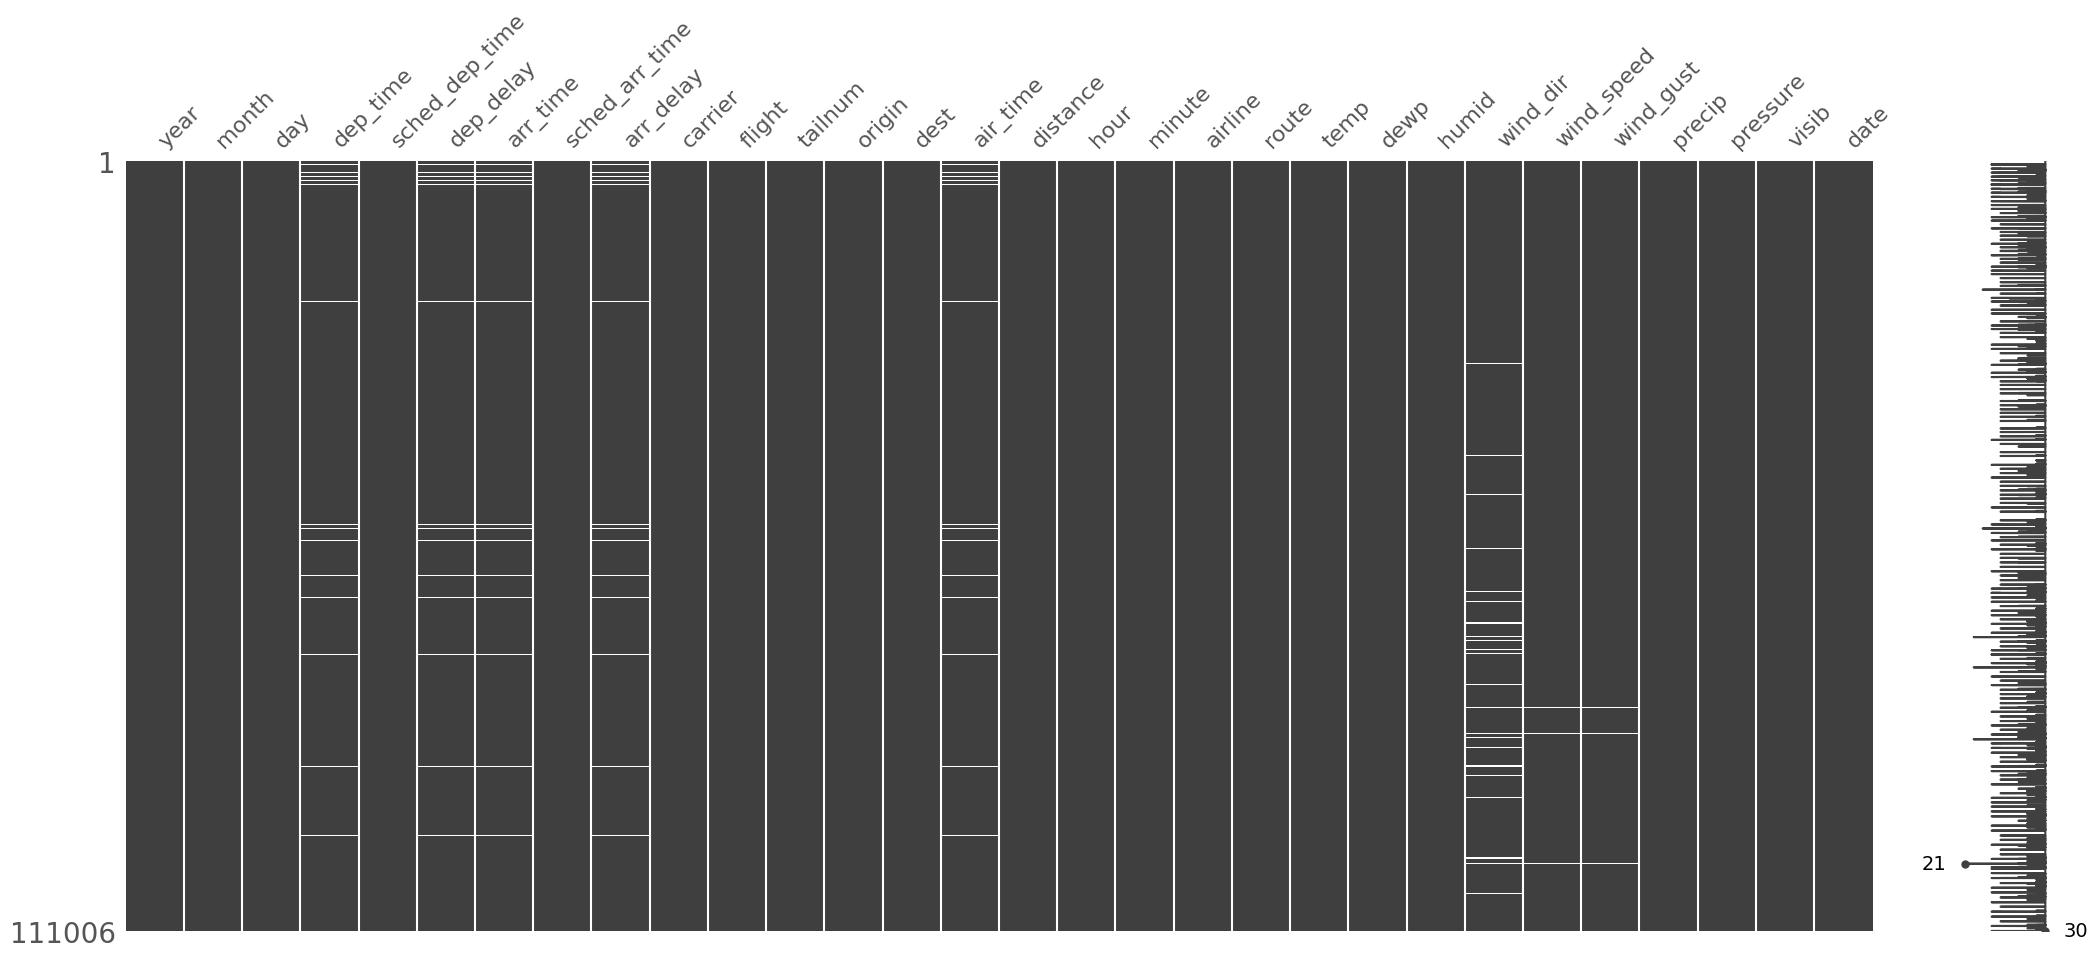

In [22]:
#Eksik verilerin görselleştirilmesi
plt.figure(figsize=(6, 4)) 
msno.matrix(df)
plt.show()

In [23]:
#Eksik verilerin veri setindeki oranı
missing_values = df.isnull().sum()
missing_value_ratio = missing_values / len(df) * 100
missing_value_ratio

year              0.000000
month             0.000000
day               0.000000
dep_time          2.198079
sched_dep_time    0.000000
dep_delay         2.198079
arr_time          2.285462
sched_arr_time    0.000000
arr_delay         2.408879
carrier           0.000000
flight            0.000000
tailnum           0.116210
origin            0.000000
dest              0.000000
air_time          2.408879
distance          0.000000
hour              0.000000
minute            0.000000
airline           0.000000
route             0.000000
temp              0.000000
dewp              0.000000
humid             0.000000
wind_dir          2.849396
wind_speed        0.251338
wind_gust         0.251338
precip            0.000000
pressure          0.000000
visib             0.000000
date              0.000000
dtype: float64

In [31]:
# Genel kabul gören kabul edilebilir eksiklik oranı olan %5' ekarşılık gelen veri sayısı 5550 dir. 
#Başka bir deyişle eksik verilerde 5550 adet eksikliğe kadar tölaransımız vardır.
threshold = len(df) * 0.05
threshold

5550.3

In [32]:
#eksik verilerin çıkarılması
df.dropna(axis=0,inplace=True)

In [33]:
df.isnull().sum()

year              0
month             0
day               0
dep_time          0
sched_dep_time    0
dep_delay         0
arr_time          0
sched_arr_time    0
arr_delay         0
carrier           0
flight            0
tailnum           0
origin            0
dest              0
air_time          0
distance          0
hour              0
minute            0
airline           0
route             0
temp              0
dewp              0
humid             0
wind_dir          0
wind_speed        0
wind_gust         0
precip            0
pressure          0
visib             0
date              0
dtype: int64

Eksik veri temizleme işlemi sonrasında satır sayısı 111006 den 105219' e düşmüştür.

In [34]:
df.shape

(105219, 30)